In [1]:
# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader  
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import networkx as nx
import numpy as np
import random

# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# function to generate a random graph
def construct_random_subgraph(num_nodes, min_edges=2, max_edges=5):
    min_edges-=1
    max_edges-=1
    connections = np.random.uniform(size=(num_nodes, num_nodes))
    connections += np.roll(np.eye(num_nodes), 1, 1)  # make sure every node is connected
    connections -= np.eye(num_nodes)  # make sure no self-connections
    # set strongest connections
    sorted_connections = np.sort(connections)[:, ::-1]
    min_edges = min_edges
    max_edges = max_edges + 1
    min_edges = int(min_edges / 2 + 0.5)  # used to be min_edges // 2
    max_edges = int(max_edges / 2 + 0.5)
    indices = np.stack([np.arange(num_nodes), np.random.randint(min_edges, max_edges, num_nodes)])
    thresholds = sorted_connections[indices[0], indices[1]]
    connections = np.where(connections > thresholds[:, None], 1., 0.).astype(np.float32)
    connections = np.clip(connections + connections.T, 0, 1)
    return connections

# function to generate a random small world graph
def construct_small_world_graph(n_nodes_per_world=6, n_worlds=4):
    n_nodes = n_nodes_per_world * n_worlds
    connections = np.zeros((n_nodes, n_nodes))
    for world_i in range(n_worlds):
        connection = construct_random_subgraph(n_nodes_per_world)
        # add to global graph
        start_i = world_i * n_nodes_per_world
        end_i = (world_i+1) * n_nodes_per_world
        connections[start_i:end_i, start_i:end_i] = connection
        # connect to graph
        if world_i != 0:
            node_from = np.random.randint(start_i, end_i)
            node_to = node_from - n_nodes_per_world
            connections[node_from, node_to] = 1
            connections[node_to, node_from] = 1
    return connections

# function to generate a dead ends graph
def construct_dead_ends_graph():
    # construct the shell-like connectivity
    n_shells = 4
    n_neurons_per_shell = 6
    layers_with_circular_connection = [1]
    size = n_shells * n_neurons_per_shell
    connections = np.zeros((size, size)).astype(np.float32)
    eye = np.eye(n_neurons_per_shell)
    for i in range(n_shells):
        if i in layers_with_circular_connection:
            # add circular connection
            idx = i * n_neurons_per_shell
            connections[idx:idx+n_neurons_per_shell, idx:idx+n_neurons_per_shell] = np.roll(eye, 1, axis=1)

        # add connections to next shell
        if i + 1 < n_shells:
            # connect to outer shell
            idx = i * n_neurons_per_shell
            j = idx + n_neurons_per_shell
            connections[idx:idx+n_neurons_per_shell, j:j+n_neurons_per_shell] = eye

    connections = connections + connections.T
    return connections

# function to generate a grid graph with numerical paths to move to a target
def construct_grid_graph():
    n = 4
    l = 5
    n_nodes = n * l + l // 2

    tmp_n_nodes = 0
    layer_index_bounds = []
    for i in range(l):
        tmp_n_nodes += n if i % 2 == 0 else n + 1
        layer_index_bounds.append(tmp_n_nodes)

    connections = []

    lower_idx = 0
    for layer_idx in range(l):
        upper_idx = layer_index_bounds[layer_idx]
        for i in range(lower_idx, upper_idx):
            if i + 1 < upper_idx:
                connections.append([i, i + 1])
            if layer_idx + 1 < l:
                # not last layer
                next_upper_idx = layer_index_bounds[layer_idx+1]
                dist1 = n if layer_idx % 2 == 0 else n + 1
                dist2 = n + 1 if layer_idx % 2 == 0 else n
                if upper_idx <= i + dist1 < next_upper_idx:
                    connections.append([i, i + dist1])
                if upper_idx <= i + dist2 < next_upper_idx:
                    connections.append([i, i + dist2])
        lower_idx = upper_idx
    connections = np.array(connections)
    i, j = connections.T
    adj = np.zeros((n_nodes, n_nodes))
    adj[i, j] = 1
    adj += adj.T
    return adj

In [3]:
# Create a dataset of trajectories
class RandomWalkDataset(Dataset):
    def __init__(self, adj_matrix, trajectory_length, num_trajectories):
        self.adj_matrix = adj_matrix
        self.num_trajectories = num_trajectories
        self.trajectory_length = trajectory_length
        self.edges, self.action_indices = edges_from_adjacency(adj_matrix)
        start_nodes = torch.randint(0, adj_matrix.size(0), (num_trajectories,)).tolist()
        self.data = []
        for node in start_nodes:
            trajectory = strict_random_walk(self.adj_matrix, node, self.trajectory_length, self.action_indices)
            self.data.append(torch.tensor([(x[0], x[1], x[2]) for x in trajectory]))
    def __len__(self):
        return self.num_trajectories  # Number of trajectories

    def __getitem__(self, idx):
        return self.data[idx]
    
    
# function to generate random walk trajectories on a given graph
def strict_random_walk(adj_matrix, start_node, length, action_indices):
    current_node = start_node
    trajectory = []
    for _ in range(length - 1):  # subtract 1 to account for the start node
        neighbors = torch.where(adj_matrix[current_node] > 0)[0].tolist()
        if not neighbors:
            break
        next_node = neighbors[torch.randint(0, len(neighbors), (1,)).item()]
        trajectory.append((current_node, action_indices[(current_node, next_node)], next_node))
        current_node = next_node
    return trajectory

# indexing each action for a given adjacency matrix
def edges_from_adjacency(adj_matrix):
    # The input is a given random matrix's adjacency matrix
    # The outputs are:
        # edges: a list of pairs of (start node, end node) for each action
        # action_indices: a dictionary, each key is a pair of(start node, end node),
            # and its corresponding value is this action's index
    # For a pure on-line algorithm, this can also be done by assigning index to unseen actions
    # during random-walk on-line
    n = adj_matrix.shape[0]
    edges = []
    action_idx = 0
    action_indices = {}
    for i in range(n):
        for j in range(i+1, n):  # Only upper triangle
            if adj_matrix[i][j] != 0:
                edges.append((i, j))
                action_indices[(i, j)] = action_idx
                action_idx += 1
                edges.append((j, i))
                action_indices[(j, i)] = action_idx
                action_idx += 1
    return edges, action_indices

In [4]:
class GraphEnv():
    def __init__(self, size=32, env='random'):
        if env == 'random':
            self.adj_matrix = construct_random_subgraph(size, 2, 5)
        elif env == 'small world':
            self.adj_matrix = construct_small_world_graph()
        elif env == 'dead ends':
            self.adj_matrix = construct_dead_ends_graph()
        elif env == 'grid':
            self.adj_matrix = construct_grid_graph()
        self.adj_matrix = torch.tensor(self.adj_matrix)
        self.size = self.adj_matrix.shape[0]
        self.affordance, self.node_to_action_matrix,\
        self.action_to_node = node_outgoing_actions(self.adj_matrix)
        
        self.affordance = {k: torch.tensor(v).to(device)\
                           for k, v in self.affordance.items()}
        self.node_to_action_matrix = self.node_to_action_matrix.to(device)
        self.action_to_node = {k: torch.tensor(v).to(device) \
                            for k, v in self.action_to_node.items()}
        
        self.dataset = RandomWalkDataset(self.adj_matrix, batch_size,\
                                         num_desired_trajectories)
        self.n_actions = len(self.dataset.action_indices)
        
def node_outgoing_actions(adj_matrix):
    # This function creates several look-up tables for later computation's convecience
    edges, action_indices = edges_from_adjacency(adj_matrix)
    # Use an action index as a key, retrieve its (start node, end node)
    inverse_action_indices = {v: k for k, v in action_indices.items()}
    # Given a node as a key, retrieve all of its available outgoing actions' indexes.
    node_actions = {}
    # Given a pair of (start node, end node), get the action index.
    # Since a index can be 0, this matrix is initialized to be a all -1.
    node_to_action_matrix = -1*torch.ones_like(adj_matrix)
    for edge in edges:
        node_from, node_to = edge
        if node_from not in node_actions:
            node_actions[node_from] = []
        node_actions[node_from].append(action_indices[edge])
        node_to_action_matrix[node_from][node_to] = action_indices[edge]  
    return node_actions, node_to_action_matrix.long(), inverse_action_indices

In [5]:
class Agent(nn.Module):
    def __init__(self, o_size, a_size, s_dim):
        super(Agent, self).__init__()
        self.Q = nn.Parameter(1*torch.randn(s_dim, o_size, device=device))
        self.V = nn.Parameter(0.1*torch.randn(s_dim, a_size, device=device))
        self.W = nn.Parameter(0.1*torch.randn(a_size, s_dim, device=device))
        self.o_size = o_size
        self.a_size = a_size
    def forward(self, o_pre, action, o_next):
        prediction_error = self.Q[:,o_next]-(self.Q[:,o_pre]+self.V[:,action])
        return prediction_error
    def plan(self, start, goal, env, weight=False):
        a_record = []
        o_record = []
        loc = int(start)
        length = 0
        for i in range(self.o_size):
            o_record.append(loc)
            if loc==goal:
                if weight:
                    return length, o_record
                else:
                    return i, o_record
            loc, action = self.move_one_step(loc, goal, a_record, env.affordance[loc], 
                    env.action_to_node, env.node_to_action_matrix[loc], weight)
            a_record.append(action)
            if weight:
                length += w_connection[o_record[-1],loc]

        if weight:
            return length, o_record
        else:
            return i, o_record
    def move_one_step(self, loc, goal, a_record, affordance, action_to_node,
                      next_node_to_action,weight=False):  
        affordance_vector = torch.zeros(self.a_size, device=device)
        affordance_vector[affordance] = 1
        if weight:    
            for a in affordance:
                a = a.item()
                affordance_vector[a]/=(w_connection[action_to_node[a][0],
                                                    action_to_node[a][1]])
        affordance_vector_fix = affordance_vector.clone()
        not_recommended_actions = a_record
        affordance_vector_fix[not_recommended_actions] *= 0.

        delta = self.Q[:,goal]-self.Q[:,loc]
        utility = (self.W@delta) * affordance_vector_fix
        if torch.max(utility)!=0:
            action_idx = torch.argmax(utility).item()
        else:
            utility = (self.V.T@delta) * affordance_vector
            action_idx = torch.argmax(utility).item()

            
        return action_to_node[action_idx][1].item(), action_idx

In [6]:
def train_model(model, dataloader, epochs, norm=False):
    with torch.no_grad():
        loss_record = []
        for epoch in tqdm(range(epochs), desc="Epochs"):
            count = 0
            for trajectory in dataloader:
                count += 1
                o_pre, action, o_next = trajectory[0,:,0].to(device),\
                                        trajectory[0,:,1].to(device),\
                                        trajectory[0,:,2].to(device)
                identity = torch.eye(model.a_size).to(device)
                state_diff = model.Q[:,o_next]-model.Q[:,o_pre]
                prediction_error = state_diff - model.V[:,action]
                desired = identity[action].T
                
                # Core learning rules:
                model.Q[:,o_next] += -0.1 * prediction_error
                model.V[:,action] += 0.01 * prediction_error
                model.W += 0.01 * desired@state_diff.T
                if norm:
                    model.V.data = model.V / torch.norm(model.V, dim=0)

                loss = nn.MSELoss()(prediction_error, torch.zeros_like(prediction_error))
                loss_record.append(loss.cpu().item())
    return loss_record

In [7]:
def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_array(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 

In [8]:
n_nodes = 8
batch_size = 16
state_dim = 1000
epochs = 10

num_desired_trajectories=200
# choose env from "random", "small world" or "dead ends"
env = GraphEnv(n_nodes, env='random')

dataset = RandomWalkDataset(env.adj_matrix, batch_size, num_desired_trajectories)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
model = Agent(env.size, env.n_actions, state_dim)


loss_record= train_model(model, dataloader, epochs, norm=False)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'Number of weight updates')

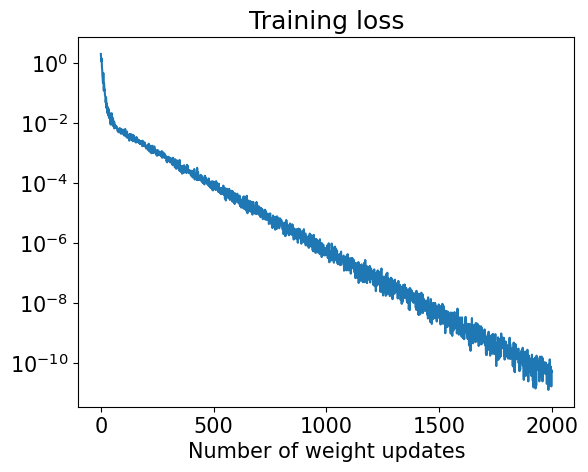

In [9]:
# og trainer loss plot
plt.rcParams['font.size'] = 15
plt.figure(dpi=100)
plt.plot(loss_record)
plt.yscale('log')
plt.title('Training loss')
plt.xlabel('Number of weight updates')

In [10]:
# Test CMLTrainerfor cadability

from trainer import CMLTrainer

mymodel = Agent(env.size, env.n_actions, state_dim)
trainer = CMLTrainer(mymodel, dataloader, norm = False, device = device)
loss_record = trainer.train(epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Text(0.5, 0, 'Number of weight updates')

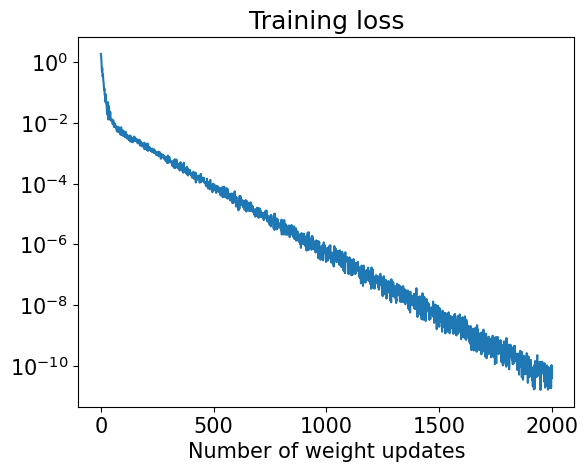

In [11]:
# our trainer loss plot

plt.rcParams['font.size'] = 15
plt.figure(dpi=100)
plt.plot(loss_record)
plt.yscale('log')
plt.title('Training loss')
plt.xlabel('Number of weight updates')

In [12]:
test_model(model, env)

CML steps: 1.6650 , Success Rate: 100.0% , Dij steps: 1.6650 , Percentage worse: 0.0%
CML std:  0.9704  Dij std:  0.9704


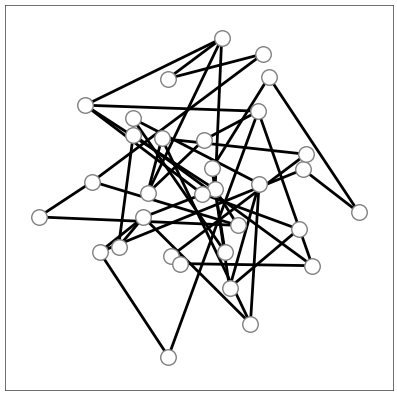

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

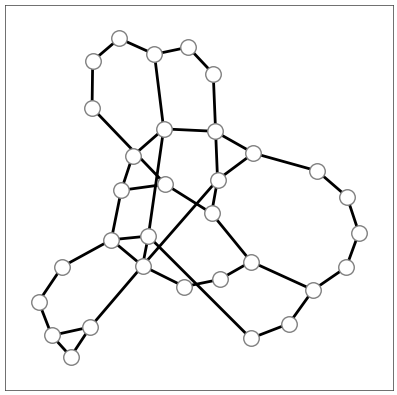

In [11]:
plt.rcParams['font.size'] = 28

def run_t_sne(model, env, perp=12, early_exaggeration=3, learning_rate=20, start=None, goal=None):
    data = model.Q.data.T.cpu().numpy().astype(float)
    
    N_nodes = env.adj_matrix.cpu().shape[0]
    tsne = TSNE(2, perplexity=perp, init='pca',
                early_exaggeration=early_exaggeration, learning_rate=learning_rate)
    data_2d = tsne.fit_transform(data)
    adjacency = env.adj_matrix.cpu().numpy()
    if start == goal == None:
        G = nx.from_numpy_array(adjacency, create_using=nx.Graph())
    pos = {}
    for i in range(N_nodes):
        pos[i] = data_2d[i]

    if start!= None and goal!=None:
        fig, ax = plt.subplots(figsize=(10,8.5),dpi=300)
        G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph())
        edge_colors = []
        do_not_show = []
        with torch.no_grad():
            delta = model.Q[:,goal] - model.Q[:,start]
            utility = model.W@delta
            for edge in G.edges:
                index = env.dataset.action_indices[(edge[0],edge[1])]
                if utility[index]<0:
                    do_not_show.append(edge)

                else:
                    edge_colors.append(utility[index].item())
            for edge in do_not_show:
                G.remove_edge(edge[0],edge[1])
    else:
        fig, ax = plt.subplots(figsize=(10,10),dpi=50)
    
    # Draw nodes
    nodelist = list(range(0,N_nodes))
    if start != None:
        nodelist.remove(start)
        nx.draw_networkx_nodes(G, pos, nodelist = [start], node_color='black',
                           edgecolors='gray', node_size=1000, linewidths=2)
    if goal != None:
        nodelist.remove(goal)
        nx.draw_networkx_nodes(G, pos, nodelist = [goal], node_color='black', node_shape='*',
                           edgecolors='gray', node_size=2000, linewidths=2)
        
    
    
    nx.draw_networkx_nodes(G, pos, nodelist = nodelist, node_color='white',
                           edgecolors='gray', node_size=500, linewidths=2)
    # Draw edges
    if start!=None or goal!=None:
        nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.rainbow, width=3,arrowsize=25)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax)
    else:
        nx.draw_networkx_edges(G, pos, edge_color='black', edge_cmap=plt.cm.rainbow, width=4)
    

import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
epochs=20
state_dim = 1000
# Create the extended dataset and dataloader
num_desired_trajectories = 200
n_nodes = 32
batch_size = 32
t_sne_learning_rate = 0.5
early_exaggeration = 2
perp = 16
set_seed(0)
# torch.cuda.empty_cache()
env = GraphEnv(n_nodes)
model = Agent(env.size, env.n_actions, state_dim)

dataset = RandomWalkDataset(env.adj_matrix, batch_size, num_desired_trajectories)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Each batch is already of size 'batch_size', so DataLoader batch_size=1


run_t_sne(model,env,perp,early_exaggeration,t_sne_learning_rate)
plt.show()
loss_record = train_model(model, dataloader, epochs, norm=False)
run_t_sne(model,env,perp,early_exaggeration,t_sne_learning_rate)


In [12]:
n_nodes = 32
batch_size = 32
state_dims = [10,20,50,100,200,500,1000,2000,5000,10000]
epochs = 10

num_desired_trajectories=200
repeats = 10
all_means = []
all_means_norm = []
env = GraphEnv(n_nodes, env='random')
for r in tqdm(range(repeats), desc="rounds"):
    means = []
    means_norm = []
    for state_dim in state_dims:
        print('round: ', r, 'state dim: ', state_dim)
    # choose env from "random", "small world" or "dead ends"
#         env = GraphEnv(n_nodes, env='random')
        dataset = RandomWalkDataset(env.adj_matrix, batch_size, num_desired_trajectories)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
        model = Agent(env.size, env.n_actions, state_dim)
        print('without normaliztion on V')
        loss_record = train_model(model, dataloader, epochs, norm=False)
        mean_CML = test_model(model, env, False)
        means.append(mean_CML)
        
        model = Agent(env.size, env.n_actions, state_dim)
        print('with normalization on V')
        loss_record = train_model(model, dataloader, epochs, norm=True)
        mean_CML_norm = test_model(model, env, False)
        means_norm.append(mean_CML_norm)
        
    all_means.append(means)
    all_means_norm.append(means_norm)

rounds:   0%|          | 0/10 [00:00<?, ?it/s]

round:  0 state dim:  10
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  0 state dim:  20
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  0 state dim:  50
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  0 state dim:  100
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  0 state dim:  200
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  0 state dim:  500
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  0 state dim:  1000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  0 state dim:  2000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  0 state dim:  5000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  0 state dim:  10000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  1 state dim:  10
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  1 state dim:  20
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  1 state dim:  50
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  1 state dim:  100
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  1 state dim:  200
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  1 state dim:  500
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  1 state dim:  1000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  1 state dim:  2000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  1 state dim:  5000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  1 state dim:  10000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  2 state dim:  10
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  2 state dim:  20
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  2 state dim:  50
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  2 state dim:  100
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  2 state dim:  200
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  2 state dim:  500
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  2 state dim:  1000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  2 state dim:  2000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  2 state dim:  5000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  2 state dim:  10000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  3 state dim:  10
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  3 state dim:  20
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  3 state dim:  50
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  3 state dim:  100
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  3 state dim:  200
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  3 state dim:  500
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  3 state dim:  1000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  3 state dim:  2000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  3 state dim:  5000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  3 state dim:  10000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  4 state dim:  10
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  4 state dim:  20
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  4 state dim:  50
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  4 state dim:  100
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  4 state dim:  200
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  4 state dim:  500
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  4 state dim:  1000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  4 state dim:  2000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  4 state dim:  5000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  4 state dim:  10000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  5 state dim:  10
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  5 state dim:  20
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  5 state dim:  50
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  5 state dim:  100
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  5 state dim:  200
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  5 state dim:  500
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  5 state dim:  1000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  5 state dim:  2000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  5 state dim:  5000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  5 state dim:  10000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  6 state dim:  10
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  6 state dim:  20
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  6 state dim:  50
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  6 state dim:  100
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  6 state dim:  200
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  6 state dim:  500
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  6 state dim:  1000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  6 state dim:  2000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  6 state dim:  5000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  6 state dim:  10000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  7 state dim:  10
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  7 state dim:  20
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  7 state dim:  50
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  7 state dim:  100
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  7 state dim:  200
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  7 state dim:  500
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  7 state dim:  1000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  7 state dim:  2000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  7 state dim:  5000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  7 state dim:  10000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  8 state dim:  10
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  8 state dim:  20
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  8 state dim:  50
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  8 state dim:  100
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  8 state dim:  200
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  8 state dim:  500
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  8 state dim:  1000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  8 state dim:  2000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  8 state dim:  5000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  8 state dim:  10000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  9 state dim:  10
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  9 state dim:  20
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  9 state dim:  50
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  9 state dim:  100
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  9 state dim:  200
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  9 state dim:  500
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  9 state dim:  1000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  9 state dim:  2000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  9 state dim:  5000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

round:  9 state dim:  10000
without normaliztion on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

with normalization on V


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

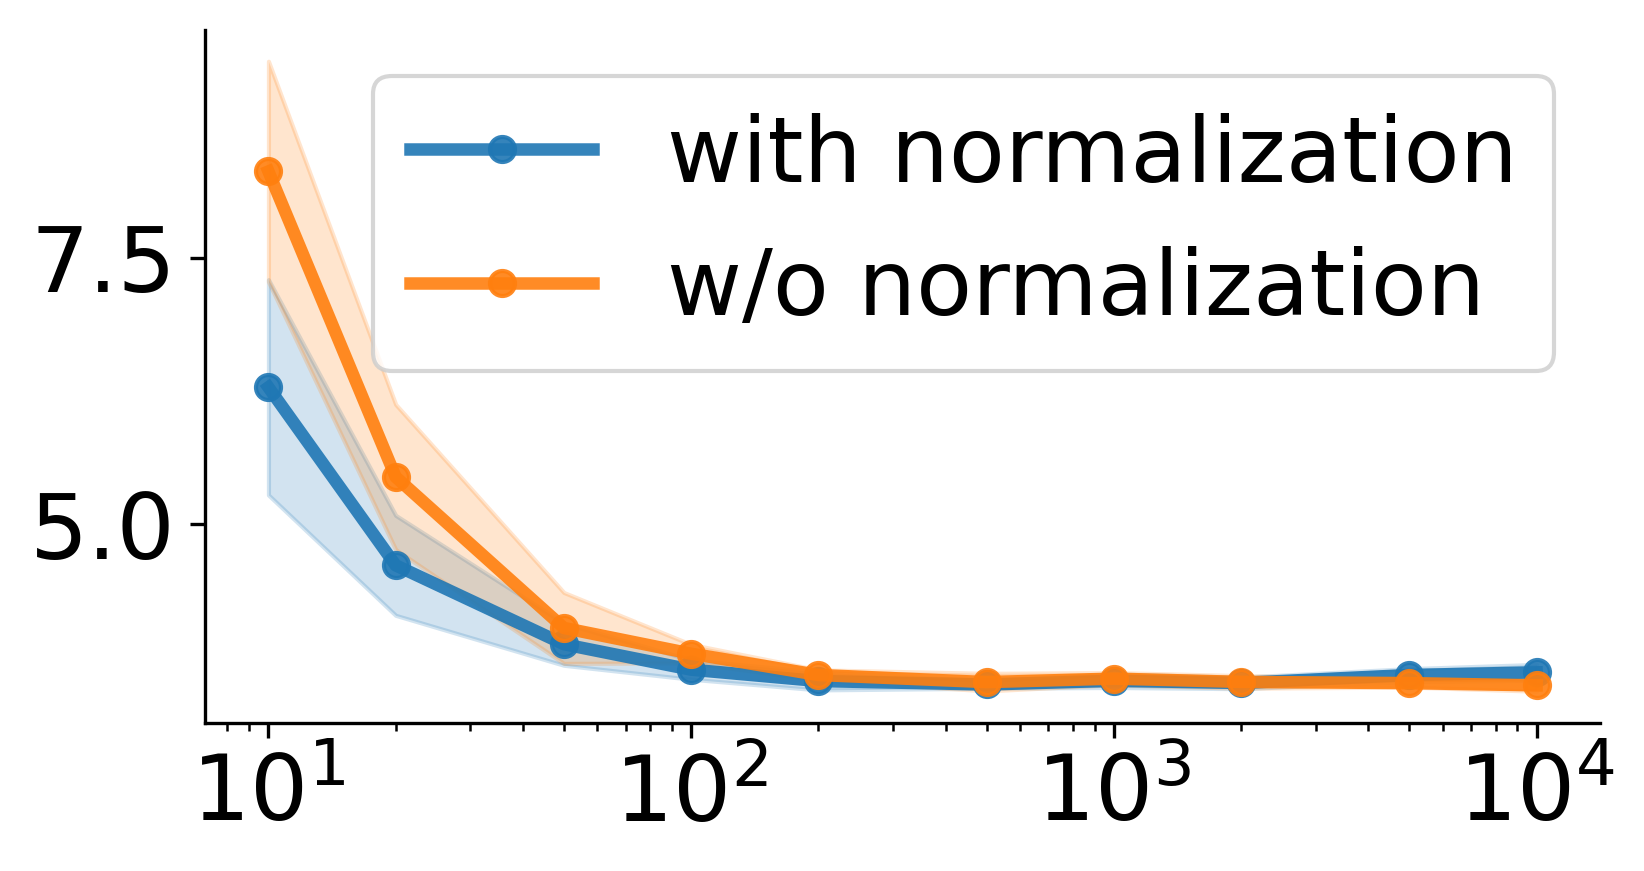

In [13]:
# import seaborn as sns
all_means = np.array(all_means)
mean = all_means.mean(axis=0)
std = all_means.std(axis=0)

all_means_norm = np.array(all_means_norm)
mean_norm = all_means_norm.mean(axis=0)
std_norm = all_means_norm.std(axis=0)
# Plot the fill between for the With Normalization data
# Set seaborn default style
# sns.set_style(None)

plt.rcParams['font.size'] = 22
plt.figure()
fig, axes = plt.subplots(1, 1, figsize=(6, 3), dpi=300)


axes.fill_between(state_dims, 
                  mean_norm - std_norm,
                  mean_norm + std_norm,
                  color='tab:blue', alpha=0.2)

axes.plot(state_dims, mean_norm, '-o', alpha=.9, color='tab:blue', lw=3, label='with normalization')

axes.fill_between(state_dims, 
                  mean - std,
                  mean + std,
                  color='tab:orange', alpha=0.2)

axes.plot(state_dims, mean, '-o', alpha=.9, color='tab:orange', lw=3,label='w/o normalization')

axes.legend()
axes.set_xscale('log')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

axes.xaxis.set_ticks_position('bottom')
axes.yaxis.set_ticks_position('left')